In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

Computer vision intro:

https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html

Explain hough:

https://alyssaq.github.io/2014/understanding-hough-transform/#Extras

Polar coordanates:

https://mathinsight.org/polar_coordinates_mapping


![title](https://answers.opencv.org/upfiles/13970504447802913.gif)

## OpenCV implementation

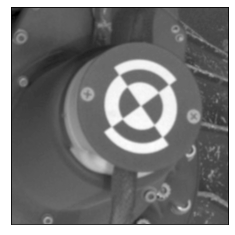

In [2]:
img_src = 'ucu-cv-code/res/marker_cut_rgb_512.png'

img = cv2.imread(img_src, 0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

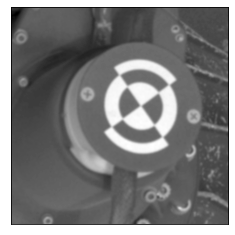

In [3]:
blur = cv2.GaussianBlur(img,(5,5),0)

plt.imshow(blur, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

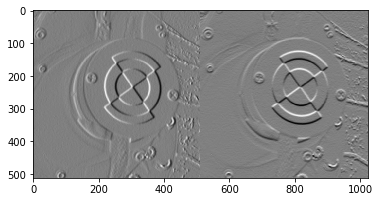

In [4]:
edge_x = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=3)
edge_y = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=3)    

both = np.hstack((edge_x, edge_y))
plt.imshow(both, cmap='gray')
plt.show() 

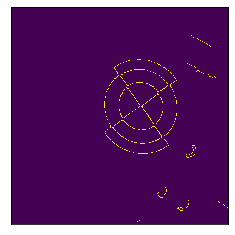

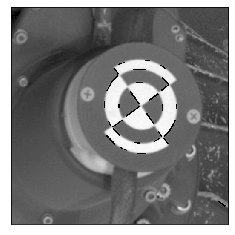

In [5]:
edges = cv2.Canny(blur,100,200,apertureSize = 3)

plt.imshow(edges)
plt.xticks([]), plt.yticks([])
plt.show()

minLineLength = 30
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180,15,minLineLength,maxLineGap)
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

plt.imshow(img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

# My code

In [6]:
def gaussian_blur(img):
    kernel = np.array([
        [2,3,2],
        [3,4,3],
        [2,3,2]
    ])
    kernel = kernel / np.sum(kernel) 

    filtered = signal.convolve2d(img, kernel, mode='same', boundary = 'symm', fillvalue=0)
    
    return filtered

def sobel(img):
    sobel_x = np.array([
        [-1,0,1],
        [-2,0,2],
        [-1,0,1]
    ])
    sobel_y = np.array([
        [1,2,1],
        [0,0,0],
        [-1,-2,-1]
    ])

    gx = signal.convolve2d(img, sobel_x, mode='same', boundary = 'symm', fillvalue=0)
    gy = signal.convolve2d(img, sobel_y, mode='same', boundary = 'symm', fillvalue=0)

    both = np.hstack((gx, gy))
    plt.imshow(both, cmap='gray')
    plt.show() 

    sobel_img = np.sqrt(gx * gx + gy * gy)
    sobel_img *= 255.0 / np.max(sobel_img)

    plt.imshow(sobel_img, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    return sobel_img


def threshold(sobel_img, threshold=150):
    binary = (sobel_img >= threshold) * 1
    
    plt.imshow(binary, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    return binary


def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    height, width = img.shape
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2))
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)):
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas


def hough_simple_peaks(H, num_peaks):
    indices = np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T

def plot_hough_acc(H, plot_title='Hough Accumulator Plot'):
    fig = plt.figure(figsize=(25, 25))
    fig.canvas.set_window_title(plot_title)

    plt.imshow(H)

    plt.xlabel('Theta Direction'), plt.ylabel('Rho Direction')
    plt.tight_layout()
    plt.show()

def hough_lines_draw(img, indicies, rhos, thetas):
    for i in range(len(indicies)):
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        
def get_hough_lines(img):
    accumulator_h = int(np.floor(np.sqrt(img.shape[0]**2 + img.shape[1]**2)))
    accumulator_w = 180
    accumulator = np.zeros((accumulator_h, accumulator_w))

    for x in range(edges.shape[0]):
        for y in range(edges.shape[1]):
            if img[x, y] != 0:
                # p = x * cos(Q) + y * sin(Q)
                for omega in range(accumulator_w):
                    if omega <= 90: 
                        p = int(np.floor(y * np.sin(np.deg2rad(omega)) + x * np.cos(np.deg2rad(omega))))
                    else:
                        p = -1 * int(np.floor(x * np.cos(np.deg2rad(omega-90)) + y * np.sin(np.deg2rad(omega-90))))
                    accumulator[p, omega] += 1
                    
    return accumulator

def get_max_index(_data, n):
    data = np.copy(_data)
    result = []
    for i in range(n):
        ind = np.unravel_index(np.argmax(data, axis=None), accumulator.shape)
        result.append(ind)
        data[ind] = 0
    
    return result

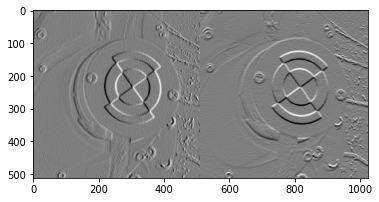

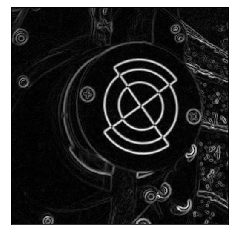

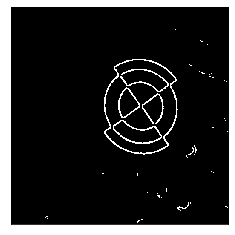

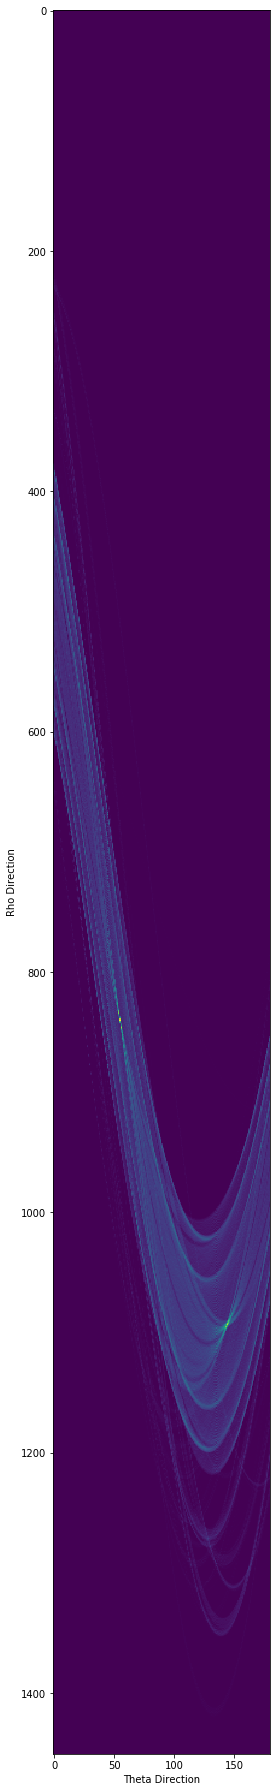

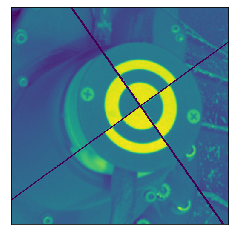

In [7]:
img = cv2.imread('ucu-cv-code/res/marker_cut_rgb_512.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

blured = gaussian_blur(img)
sobel_img = sobel(blured)
binary = threshold(sobel_img)


_image = np.copy(img)

H, rhos, thetas = hough_lines_acc(binary)
number_of_lines = 3
indicies = hough_simple_peaks(H, number_of_lines)
plot_hough_acc(H)
hough_lines_draw(_image, indicies, rhos, thetas)

plt.imshow(_image)
plt.xticks([]), plt.yticks([])
plt.show()

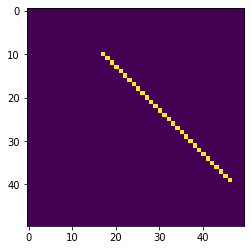

In [8]:
image = np.zeros((50,50))
image[10:40, 17:47] = np.eye(30)

plt.imshow(image)
plt.show()